In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [3]:
def calculate_technical_indicators(df):
    df = df.copy()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    delta = df['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    return df

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
stocks_data = {}
X_train_all = pd.DataFrame()
y_train_all = pd.Series(dtype='float64')
X_test_all = pd.DataFrame()
y_test_all = pd.Series(dtype='float64')

for ticker in tickers:
    print(f"Baixando dados para {ticker}...")
    data = yf.download(ticker, start="2017-01-01", end="2023-12-31")
    if 'Adj Close' in data.columns:
        # Adiciona a coluna do ticker
        data['Ticker'] = ticker
        data = calculate_technical_indicators(data)
        data.dropna(inplace=True)  
        
        stocks_data[ticker] = data
    else:
        print(f"Coluna 'Adj Close' não encontrada para {ticker}")

Baixando dados para AAPL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para MSFT...


[*********************100%***********************]  1 of 1 completed


Baixando dados para GOOGL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para AMZN...


[*********************100%***********************]  1 of 1 completed


Baixando dados para META...


[*********************100%***********************]  1 of 1 completed


In [5]:
fedfunds = pd.read_csv('/Users/pedrobueno/Desktop/Modelos ML/World Bank/FEDFUNDS.csv')
fedfunds['DATE'] = pd.to_datetime(fedfunds['DATE'])
fedfunds.set_index('DATE', inplace=True)

In [6]:
fedfunds = fedfunds.loc['2017-01-01':'2023-12-31']

In [7]:
fedfunds_daily = pd.DataFrame(index=pd.date_range(start='2017-01-01', end='2023-12-31'))
fedfunds_daily['FEDFUNDS'] = np.nan

In [8]:
for i, row in fedfunds.iterrows():
    start_date = i
    if i != fedfunds.index[-1]:
        end_date = fedfunds.index[fedfunds.index.get_loc(i) + 1] - pd.DateOffset(days=1)
    else:
        end_date = fedfunds_daily.index[-1]
    fedfunds_daily.loc[start_date:end_date, 'FEDFUNDS'] = row['FEDFUNDS']

In [9]:
file_path = '/Users/pedrobueno/Desktop/Modelos ML/World Bank/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3403845.csv'
df_pib = pd.read_csv(file_path, sep=';', skiprows=4)
df_pib_filtered = df_pib.loc[:, '2017':'2023']
df_pib_filtered = df_pib_filtered.T.reset_index()
df_pib_filtered.columns = ['Year', 'GDP']
df_pib_filtered['Date'] = pd.to_datetime(df_pib_filtered['Year'] + '-01-01')
df_pib_daily = pd.DataFrame(index=pd.date_range(start="2017-01-01", end="2024-01-01"))
df_pib_daily['GDP'] = np.nan

In [10]:
for i, row in df_pib_filtered.iterrows():
    start_date = row['Date']
    if i < len(df_pib_filtered) - 1:
        end_date = df_pib_filtered.loc[i + 1, 'Date'] - pd.DateOffset(days=1)
    else:
        end_date = pd.to_datetime('2024-01-01')
    df_pib_daily.loc[start_date:end_date, 'GDP'] = row['GDP']

In [11]:
for ticker in tickers:
    X = stocks_data[ticker].copy()

    # Definir o tamanho do treino
    train_size = int(len(X) * 0.8)
    
    # Criar X_train e X_test
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    
    # PIB
    X_train = X_train.join(df_pib_daily['GDP'], how='left')
    X_test = X_test.join(df_pib_daily['GDP'], how='left')
    
    # Taxa de juros
    X_train = X_train.join(fedfunds_daily['FEDFUNDS'], how='left')
    X_test = X_test.join(fedfunds_daily['FEDFUNDS'], how='left')
    
    # Criar y_train e y_test com base em Adj Close deslocado
    y_train = X_train['Adj Close'].shift(-1)  # Prever o próximo dia
    y_test = X_test['Adj Close'].shift(-1)  # Prever o próximo dia
    
    # Remover NaNs do conjunto de treino e teste
    X_train.dropna(inplace=True)
    y_train.dropna(inplace=True)
    
    
    # Ajustar os tamanhos de X_train e y_train para garantir correspondência de índices
    min_len_train = min(len(X_train), len(y_train))
    X_train = X_train.iloc[:min_len_train]
    y_train = y_train.iloc[:min_len_train]

    # Ajustar os tamanhos de X_test e y_test para garantir correspondência de índices
    min_len_test = min(len(X_test), len(y_test))
    X_test = X_test.iloc[:min_len_test]
    y_test = y_test.iloc[:min_len_test]
    
    X_train_all = pd.concat([X_train_all, X_train])
    y_train_all = pd.concat([y_train_all, y_train])
    X_test_all = pd.concat([X_test_all, X_test])
    y_test_all = pd.concat([y_test_all, y_test])

In [12]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'SMA_20', 'SMA_50', 'RSI', 'EMA_20', 'FEDFUNDS']
X_train_all = X_train_all[features + ['Ticker']]
X_test_all = X_test_all[features + ['Ticker']] 

In [13]:
X_train_all_no_ticker = X_train_all.drop(columns=['Ticker'])
X_test_all_no_ticker = X_test_all.drop(columns=['Ticker'])

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all_no_ticker)
X_test_scaled = scaler.transform(X_test_all_no_ticker)

In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_all_no_ticker.columns, index=X_train_all.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_all_no_ticker.columns, index=X_test_all.index)

In [17]:
X_train_scaled['Ticker'] = X_train_all['Ticker']
X_test_scaled['Ticker'] = X_test_all['Ticker']

In [18]:
if 'Ticker' in X_train_scaled.columns:
    X_train_scaled_no_ticker = X_train_scaled.drop(columns=['Ticker'])
    X_test_scaled_no_ticker = X_test_scaled.drop(columns=['Ticker'])
else:
    X_train_scaled_no_ticker = X_train_scaled
    X_test_scaled_no_ticker = X_test_scaled

In [19]:
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train_scaled_no_ticker, y_train_all)

Ridge(alpha=10.0)

In [20]:
model = LinearRegression()
model.fit(X_train_scaled_no_ticker, y_train_all)

LinearRegression()

In [21]:
cv_scores = cross_val_score(model, X_train_scaled_no_ticker, y_train_all, cv=5, scoring='neg_mean_squared_error')

In [22]:
cv_scores = -cv_scores

In [23]:
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

In [24]:
print(f"Validação Cruzada - MSE Médio: {mean_cv_score:.4f}")
print(f"Validação Cruzada - Desvio Padrão do MSE: {std_cv_score:.4f}")

Validação Cruzada - MSE Médio: 20.3500
Validação Cruzada - Desvio Padrão do MSE: 17.2710


In [25]:
y_pred_train = model.predict(X_train_scaled_no_ticker)
y_pred_test = model.predict(X_test_scaled_no_ticker)

In [26]:
y_test_all = y_test_all.dropna()
y_pred_test = pd.Series(y_pred_test).dropna()

In [27]:
mse_train = mean_squared_error(y_train_all, y_pred_train)
mae_train = mean_absolute_error(y_train_all, y_pred_train)
r2_train = r2_score(y_train_all, y_pred_train)

In [28]:
min_len_test = min(len(y_test_all), len(y_pred_test))
y_test_all = y_test_all.iloc[:min_len_test]
y_pred_test = y_pred_test[:min_len_test]

In [29]:
mse_test = mean_squared_error(y_test_all, y_pred_test)
mae_test = mean_absolute_error(y_test_all, y_pred_test)
r2_test = r2_score(y_test_all, y_pred_test)

print(f"Train - Mean Squared Error: {mse_train}")
print(f"Train - Mean Absolute Error: {mae_train}")
print(f"Train - R2 Score: {r2_train}")

print(f"Test - Mean Squared Error: {mse_test}")
print(f"Test - Mean Absolute Error: {mae_test}")
print(f"Test - R2 Score: {r2_test}")

Train - Mean Squared Error: 13.436363224466595
Train - Mean Absolute Error: 2.396687107552672
Train - R2 Score: 0.9976963184921812
Test - Mean Squared Error: 140.6937591883558
Test - Mean Absolute Error: 5.6254633961086284
Test - R2 Score: 0.9786281513786185


In [30]:
if 'Ticker' not in X_test_all.columns:
    X_test_all = X_test_all.reset_index(level=0)  
    X_test_all.rename(columns={'level_0': 'Ticker'}, inplace=True)

In [31]:
print(X_train_all.head())
print(X_test_all.head())

                 Open       High        Low      Close     Volume  \
Date                                                                
2017-03-15  34.852501  35.187500  34.757500  35.115002  102767200   
2017-03-16  35.180000  35.255001  35.064999  35.172501   76928000   
2017-03-17  35.250000  35.250000  34.972500  34.997501  175540000   
2017-03-20  35.099998  35.375000  35.057499  35.365002   86168000   
2017-03-21  35.527500  35.700001  34.932499  34.959999  158119600   

                     GDP     SMA_20     SMA_50        RSI     EMA_20  \
Date                                                                   
2017-03-15  1.961210e+13  32.128866  30.034889  72.928767  31.925749   
2017-03-16  1.961210e+13  32.189157  30.151475  73.240833  32.004332   
2017-03-17  1.961210e+13  32.243164  30.265405  66.813068  32.059912   
2017-03-20  1.961210e+13  32.309974  30.383444  71.265303  32.142789   
2017-03-21  1.961210e+13  32.346522  30.487915  50.267846  32.181857   

           

In [32]:
predicted_values = pd.DataFrame()

for ticker in tickers:
    X_test_ticker = X_test_all[X_test_all['Ticker'] == ticker]
    y_pred_test_ticker = model.predict(scaler.transform(X_test_ticker[features]))
    
    # Criar um DataFrame temporário para armazenar as previsões
    temp_df = pd.DataFrame({
        'Date': X_test_ticker.index,
        'Predicted': y_pred_test_ticker,
        'Ticker': ticker  # Adiciona a coluna 'Ticker'
    })
    
    predicted_values = pd.concat([predicted_values, temp_df], ignore_index=True)

# Definir a coluna Date como índice
predicted_values.set_index('Date', inplace=True)

In [33]:
all_stocks_data = pd.concat(stocks_data.values(), ignore_index=True)

In [36]:
for ticker in stocks_data:
    stocks_data[ticker]['Date'] = stocks_data[ticker].index

In [38]:
all_stocks_data = pd.concat(stocks_data.values(), ignore_index=True)

In [40]:
merged_data = pd.merge(
    predicted_values.reset_index(),  
    all_stocks_data[['Date', 'Adj Close', 'Ticker']],
    on=['Date', 'Ticker'],
    how='inner'
)

In [41]:
merged_data.rename(columns={'Adj Close': 'Real'}, inplace=True)

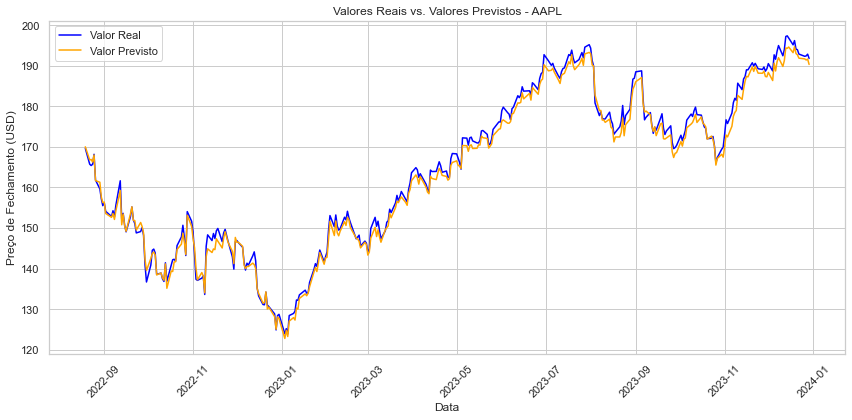

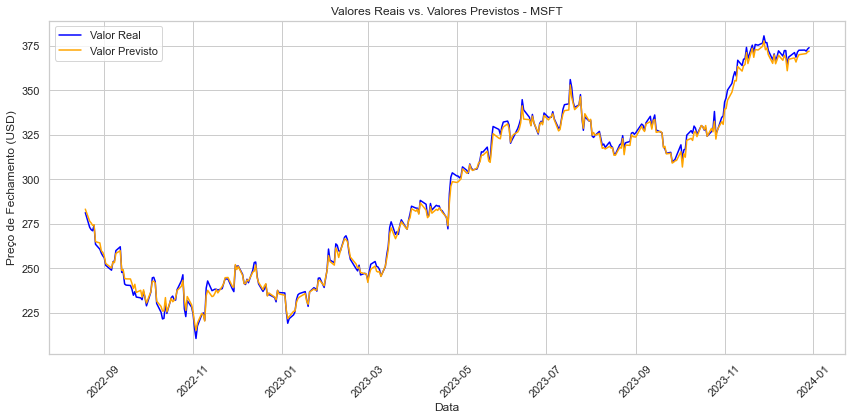

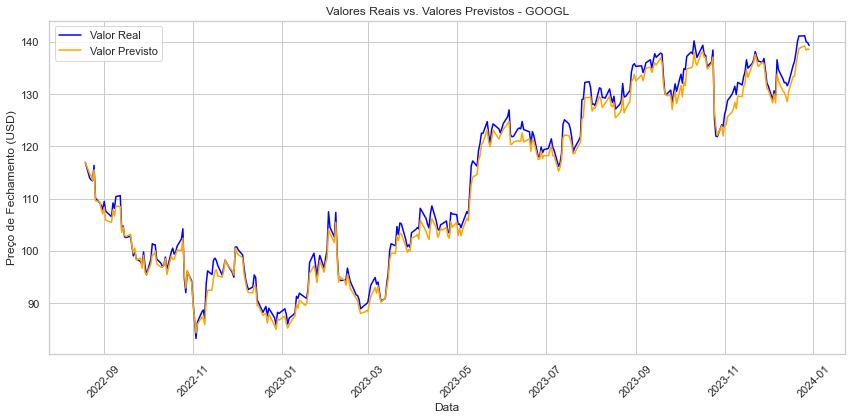

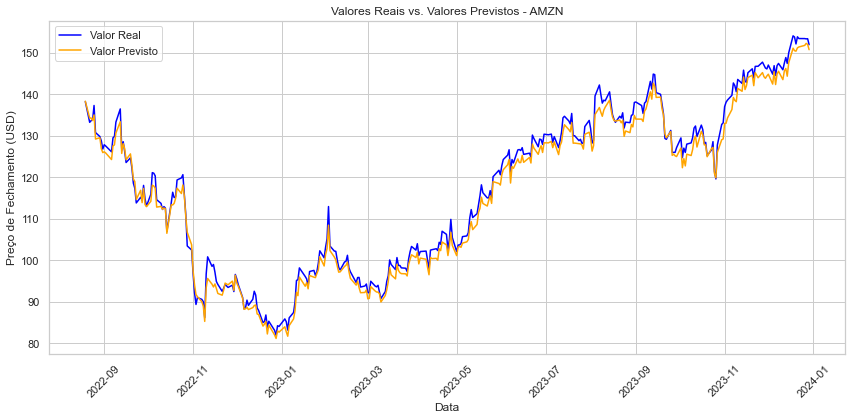

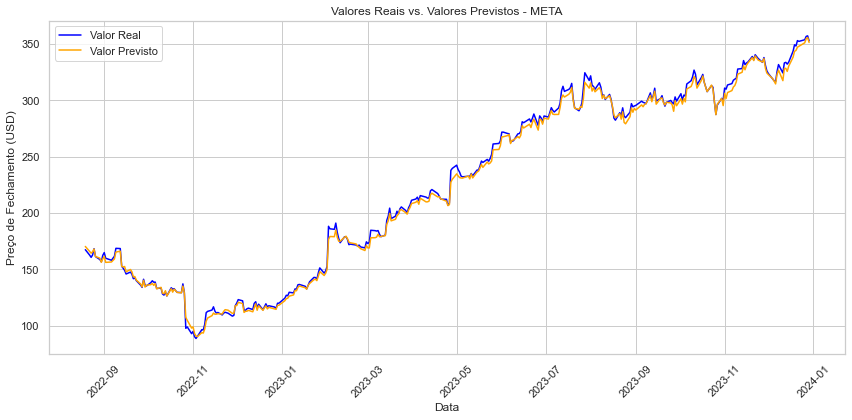

In [42]:
for ticker in tickers:
    plt.figure(figsize=(12, 6))
    
    # Filtrar os dados do ticker atual
    merged_ticker_data = merged_data[merged_data['Ticker'] == ticker]
    
    # Gráfico de linha para valores reais e previstos
    sns.lineplot(x=merged_ticker_data['Date'], y=merged_ticker_data['Real'], label='Valor Real', color='blue')
    sns.lineplot(x=merged_ticker_data['Date'], y=merged_ticker_data['Predicted'], label='Valor Previsto', color='orange')

    # Configurar gráfico
    plt.title(f'Valores Reais vs. Valores Previstos - {ticker}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

In [43]:
for ticker in tickers:
    print(f"\nResultados para {ticker}:")
    results = merged_data[merged_data['Ticker'] == ticker][['Date', 'Ticker', 'Real', 'Predicted']].head(10)
    print(results)


Resultados para AAPL:
        Date Ticker        Real   Predicted
0 2022-08-19   AAPL  169.640411  170.015214
1 2022-08-22   AAPL  165.733704  166.761613
2 2022-08-23   AAPL  165.397415  166.897019
3 2022-08-24   AAPL  165.694138  166.266147
4 2022-08-25   AAPL  168.166748  167.990033
5 2022-08-26   AAPL  161.826996  161.688231
6 2022-08-29   AAPL  159.611542  161.266941
7 2022-08-30   AAPL  157.168610  157.617701
8 2022-08-31   AAPL  155.497131  156.272528
9 2022-09-01   AAPL  156.229019  156.383038

Resultados para MSFT:
          Date Ticker        Real   Predicted
343 2022-08-19   MSFT  281.300537  283.271256
344 2022-08-22   MSFT  273.042908  276.483368
345 2022-08-23   MSFT  271.755096  275.526990
346 2022-08-24   MSFT  271.116119  274.172307
347 2022-08-25   MSFT  274.124268  274.518948
348 2022-08-26   MSFT  263.546600  265.019419
349 2022-08-29   MSFT  260.735077  264.264540
350 2022-08-30   MSFT  258.513458  259.844306
351 2022-08-31   MSFT  257.038788  258.994883
352 2022-0

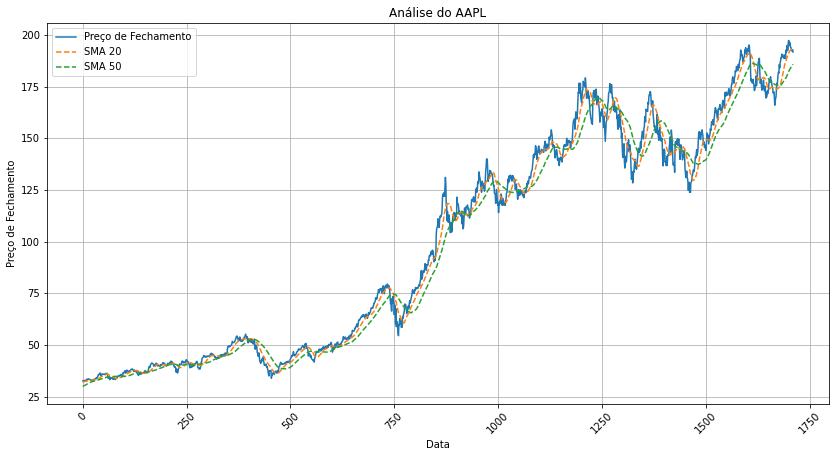

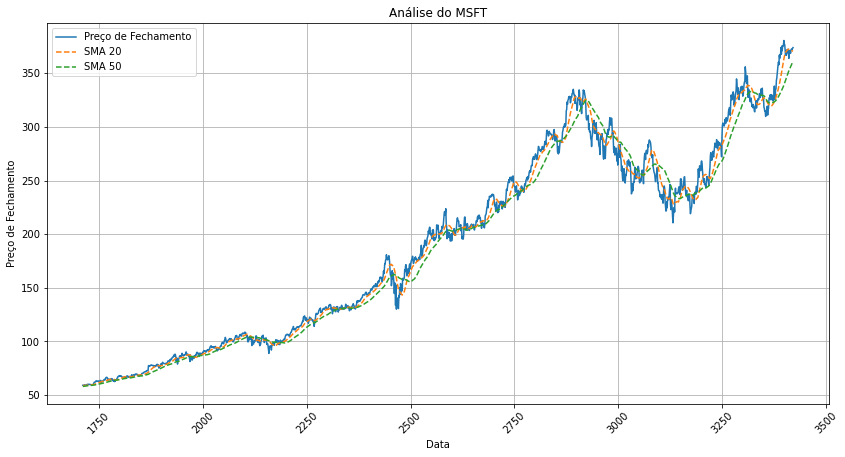

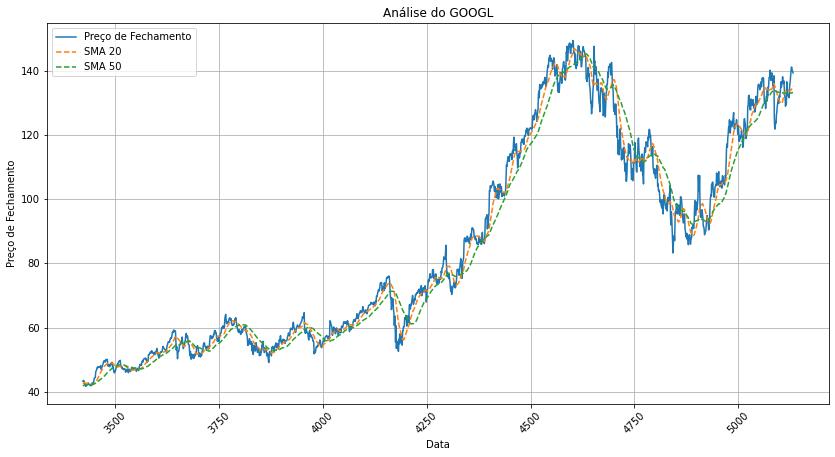

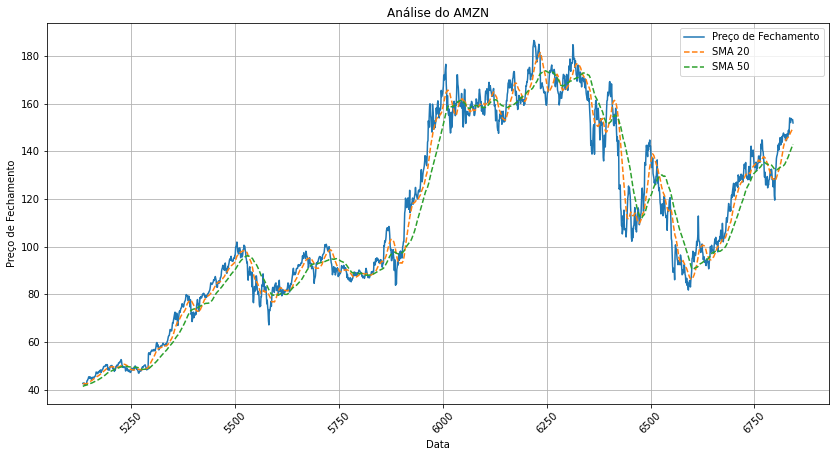

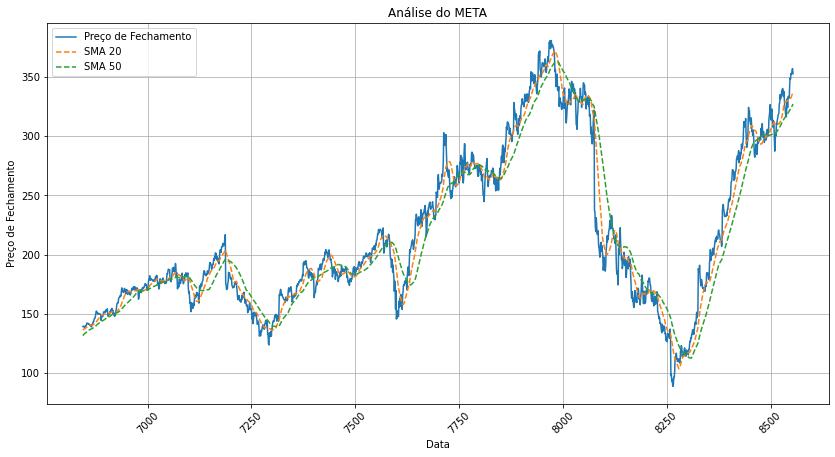

In [36]:
for ticker in tickers:
    plt.figure(figsize=(14, 7))
    
    # Filtrar os dados para o ticker atual
    ticker_data = all_stocks_data[all_stocks_data['Ticker'] == ticker]
    
    # Plotar o valor de fechamento
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Preço de Fechamento')
    
    # Adicionar médias móveis
    plt.plot(ticker_data.index, ticker_data['SMA_20'], label='SMA 20', linestyle='--')
    plt.plot(ticker_data.index, ticker_data['SMA_50'], label='SMA 50', linestyle='--')

    # Customizar gráfico
    plt.title(f'Análise do {ticker}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    
    # Mostrar o gráfico
    plt.show()

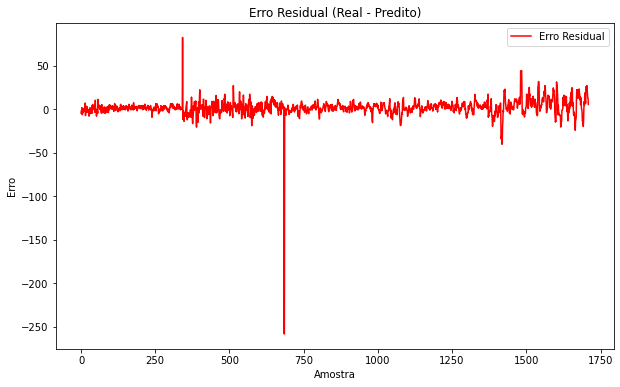

In [30]:
residuals = y_test_all.values - y_pred_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Erro Residual', color='red')
plt.title('Erro Residual (Real - Predito)')
plt.xlabel('Amostra')
plt.ylabel('Erro')
plt.legend()
plt.show()

In [31]:
correlation_matrix = X_train_all.corr()

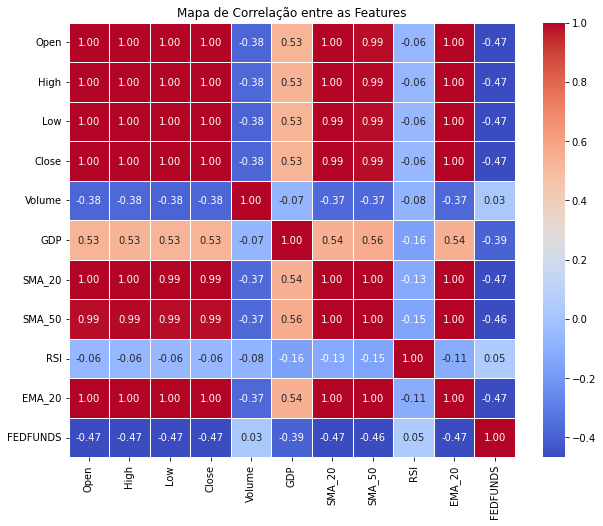

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação entre as Features')
plt.show()